In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import os
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

import tensorflow as tf
import optuna
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

2025-12-14 12:35:55.503258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765715755.691863      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765715755.744836      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/trajectory-forecasting-data/BA12072_resampled_1h_features_02.csv')

In [3]:
df.fillna(0, inplace=True)
df.drop(columns=['heading'], inplace=True)
df.head()

,timestamp,external-temperature,ground-speed,height-above-msl,gls:light-level,x_m,y_m,sin_heading,cos_heading,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month,distance,time_of_day,season
0,2023-11-18 22:00:00,24.9,0.500000,-332.270000,0.000000,3.732663e+06,-2.031658e+06,-0.949425,0.313992,-0.500000,0.866025,-0.587785,-0.809017,-0.5,0.866025,0.000000,night,fall
1,2023-11-18 23:00:00,0.0,0.000000,-1.300000,0.000000,3.732866e+06,-2.031672e+06,0.000000,1.000000,-0.258819,0.965926,-0.587785,-0.809017,-0.5,0.866025,202.879558,night,fall
2,2023-11-19 00:00:00,29.9,0.600000,14.500000,0.000000,3.732859e+06,-2.031723e+06,0.999848,-0.017452,0.000000,1.000000,-0.743145,-0.669131,-0.5,0.866025,51.501405,morning,fall
3,2023-11-19 01:00:00,31.4,0.544444,17.694444,54.777778,3.730107e+06,-2.029516e+06,0.987383,0.158350,0.258819,0.965926,-0.743145,-0.669131,-0.5,0.866025,3526.598258,morning,fall
4,2023-11-19 02:00:00,32.9,0.488889,20.888889,109.555556,3.727356e+06,-2.027311e+06,0.944249,0.329233,0.500000,0.866025,-0.743145,-0.669131,-0.5,0.866025,3526.069804,morning,fall


In [4]:
def create_windowed_dataset(df, features, target, time_col, input_window, forecast_horizon, step=1):
    X, y, y_time = [], [], []
    for i in range(0, len(df) - input_window - forecast_horizon, step):
        X.append(df[features+target].iloc[i:i+input_window].values)
        y.append(df[target].iloc[i+input_window:i+input_window+forecast_horizon].values)
        y_time.append(df[time_col].iloc[i+input_window:i+input_window+forecast_horizon].values)
    return np.array(X), np.array(y), np.array(y_time)

def flatten_data(data_3d):
    n_samples = data_3d.shape[0]
    return data_3d.reshape(n_samples, -1)

def ade(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

def fde(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true[:, -1, :] - y_pred[:, -1, :]), axis=-1)))

In [5]:
features = ['external-temperature', 'ground-speed', 'height-above-msl', 'gls:light-level', 'sin_heading', 'cos_heading',
            'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_month', 'cos_month', 'distance', 'time_of_day', 'season']
target = ['x_m', 'y_m']
time_col = 'timestamp'

INPUT_WINDOW = 24*2         
FORECAST_HORIZON = 24         
NUM_FEATURES = len(features)
NUM_TARGETS = len(target)
NUM_FEATURES_INPUT = NUM_FEATURES + NUM_TARGETS

In [6]:
train_start = '2023-11-18'
train_end = '2024-11-30' 

val_start = '2024-12-01'
val_end = '2025-01-31'   

test_start = '2025-02-01'
test_end = '2025-03-31'   

train_df_raw = df[(df['timestamp'] >= train_start) & (df['timestamp'] <= train_end + ' 23:59:59')].copy()
val_df_raw = df[(df['timestamp'] >= val_start) & (df['timestamp'] <= val_end + ' 23:59:59')].copy()
test_df_raw = df[(df['timestamp'] >= test_start) & (df['timestamp'] <= test_end + ' 23:59:59')].copy()

print(f"Kích thước tập Train: {train_df_raw.shape}")
print(f"Ngày bắt đầu Train: {train_df_raw['timestamp'].min()}")
print(f"Ngày kết thúc Train: {train_df_raw['timestamp'].max()}")
print("-" * 30)
print(f"Kích thước tập Val:   {val_df_raw.shape}")
print(f"Ngày bắt đầu Val:   {val_df_raw['timestamp'].min()}")
print(f"Ngày kết thúc Val:   {val_df_raw['timestamp'].max()}")
print("-" * 30)
print(f"Kích thước tập Test:  {test_df_raw.shape}")
print(f"Ngày bắt đầu Test:  {test_df_raw['timestamp'].min()}")
print(f"Ngày kết thúc Test:  {test_df_raw['timestamp'].max()}")

Kích thước tập Train: (7925, 18)
Ngày bắt đầu Train: 2023-11-18 22:00:00
Ngày kết thúc Train: 2024-11-30 23:00:00
------------------------------
Kích thước tập Val:   (1463, 18)
Ngày bắt đầu Val:   2024-12-01 00:00:00
Ngày kết thúc Val:   2025-01-31 23:00:00
------------------------------
Kích thước tập Test:  (1209, 18)
Ngày bắt đầu Test:  2025-02-01 00:00:00
Ngày kết thúc Test:  2025-03-31 11:00:00


In [7]:
features_std = ['external-temperature', 'gls:light-level', 'distance']
features_robust = ['ground-speed', 'height-above-msl']
target_cols = ['x_m', 'y_m']
label = ['time_of_day', 'season']

In [8]:
scaler_std = StandardScaler()
scaler_robust = RobustScaler()
scaler_target = StandardScaler()
label_encoders = {}

In [9]:
scaler_std.fit(train_df_raw[features_std])
scaler_robust.fit(train_df_raw[features_robust])
scaler_target.fit(train_df_raw[target_cols])
for col in ['time_of_day', 'season']:
    le = LabelEncoder()
    le.fit(train_df_raw[col])
    label_encoders[col] = le

In [10]:
def preprocess_dataframe(df_in, scalers_enc):
    df_out = df_in.copy()
    df_out[features_std] = scalers_enc['std'].transform(df_in[features_std])
    df_out[features_robust] = scalers_enc['robust'].transform(df_in[features_robust])

    df_out[target_cols] = scalers_enc['target'].transform(df_in[target_cols])
    
    for col in label: 
        df_out[col] = scalers_enc['label_encoders'][col].transform(df_in[col]) 
        
    return df_out

In [11]:
scalers_encoders = {
    'std': scaler_std, 
    'robust': scaler_robust, 
    'target': scaler_target, 
    'label_encoders': label_encoders 
}

train_df_scaled = preprocess_dataframe(train_df_raw, scalers_encoders)
val_df_scaled = preprocess_dataframe(val_df_raw, scalers_encoders)
test_df_scaled = preprocess_dataframe(test_df_raw, scalers_encoders)

In [12]:
X_train_3d, y_train_3d, _ = create_windowed_dataset(
    train_df_scaled, features, target, time_col,
    input_window=INPUT_WINDOW, forecast_horizon=FORECAST_HORIZON
)
X_val_3d, y_val_3d, _ = create_windowed_dataset(
    val_df_scaled, features, target, time_col,
    input_window=INPUT_WINDOW, forecast_horizon=FORECAST_HORIZON
)
X_test_3d, y_test_3d, _ = create_windowed_dataset(
    test_df_scaled, features, target, time_col,
    input_window=INPUT_WINDOW, forecast_horizon=FORECAST_HORIZON
)

In [13]:
X_train = flatten_data(X_train_3d)
y_train = flatten_data(y_train_3d)
X_val = flatten_data(X_val_3d)
y_val = flatten_data(y_val_3d)
X_test = flatten_data(X_test_3d)
y_test = flatten_data(y_test_3d)     

In [14]:
print("Shapes mới (2D, scaled):")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

joblib.dump(scaler_target, 'scaler_target.joblib')

Shapes mới (2D, scaled):
X_train: (7853, 816), y_train: (7853, 48)
X_val:   (1391, 816), y_val:   (1391, 48)
X_test:  (1137, 816), y_test:  (1137, 48)


['scaler_target.joblib']

In [15]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15),
    "XGBoost": XGBRegressor(
            n_estimators=300, 
            learning_rate=0.05, 
            random_state=42,
            n_jobs=-1, 
            early_stopping_rounds=10,
            
    ),
    "KNN": KNeighborsRegressor(n_neighbors=7),
    "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42, early_stopping=True)
}

In [16]:
model_results = {}
for model_name, model in models.items():
    print(f"\nĐang huấn luyện {model_name}...")
    start_time = time.time()

    if model_name == "XGBoost":
        model.fit(
            X_train, 
            y_train, 
            eval_set=[(X_val, y_val)],
            verbose=False              
        )
    else:
        model.fit(X_train, y_train)

    print(f"Huấn luyện {model_name} hoàn tất trong {time.time() - start_time:.2f} giây.")

    model_results[model_name] = model
    
    os.makedirs('models', exist_ok=True)
    joblib.dump(model, f'models/{model_name}_model_{INPUT_WINDOW}-{FORECAST_HORIZON}.joblib')


Đang huấn luyện LinearRegression...
Huấn luyện LinearRegression hoàn tất trong 0.82 giây.

Đang huấn luyện RandomForest...
Huấn luyện RandomForest hoàn tất trong 198.60 giây.

Đang huấn luyện XGBoost...
Huấn luyện XGBoost hoàn tất trong 580.24 giây.

Đang huấn luyện KNN...
Huấn luyện KNN hoàn tất trong 0.01 giây.

Đang huấn luyện MLP...
Huấn luyện MLP hoàn tất trong 6.98 giây.



--- Đánh giá LinearRegression ---


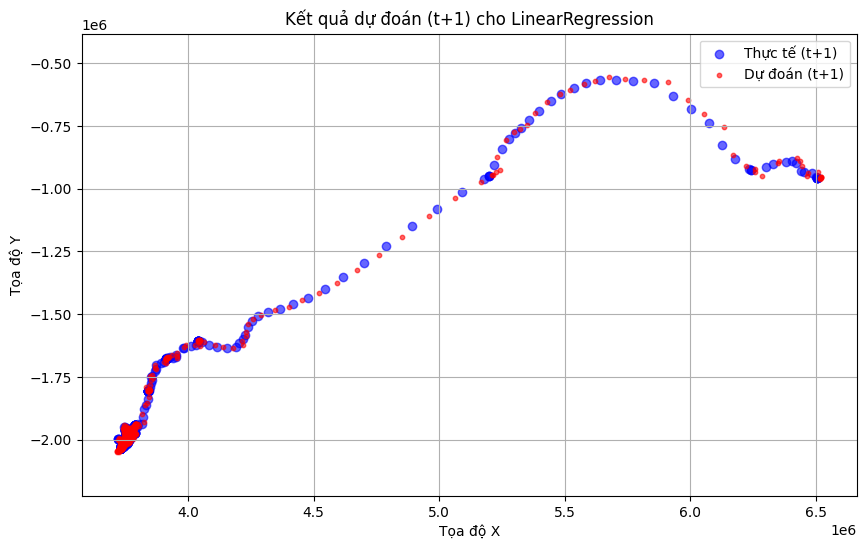

I0000 00:00:1765716567.695536      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Kết quả đánh giá cho LinearRegression (Tọa độ gốc):
  MAE: 39892.3097
  R2 Score: 0.9211
  ADE: 60555.17
  FDE: 106329.98

--- Đánh giá RandomForest ---


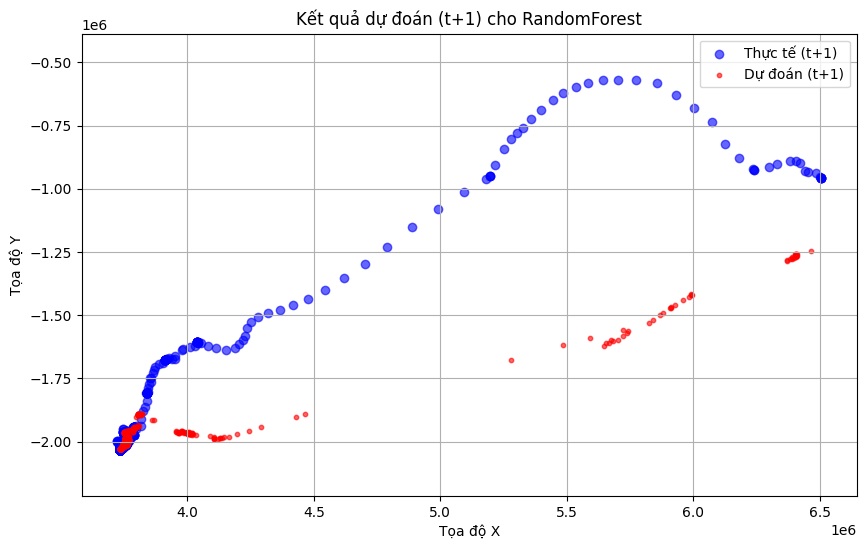

Kết quả đánh giá cho RandomForest (Tọa độ gốc):
  MAE: 51223.3844
  R2 Score: 0.7173
  ADE: 78388.92
  FDE: 100463.58

--- Đánh giá XGBoost ---


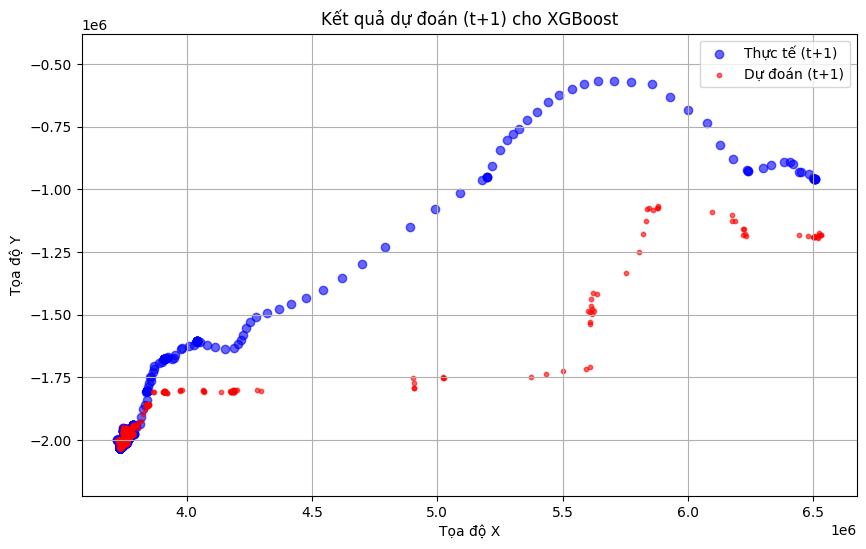

Kết quả đánh giá cho XGBoost (Tọa độ gốc):
  MAE: 51544.2657
  R2 Score: 0.6716
  ADE: 81189.57
  FDE: 101106.49

--- Đánh giá KNN ---


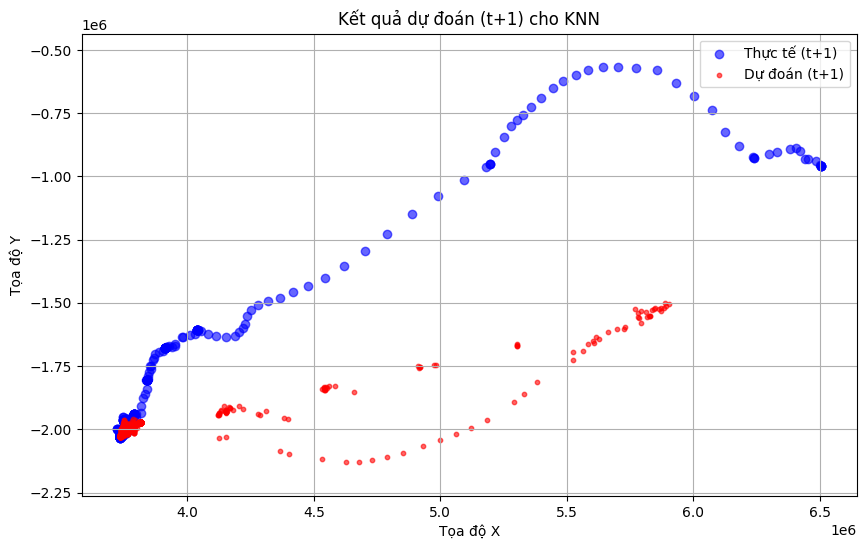

Kết quả đánh giá cho KNN (Tọa độ gốc):
  MAE: 69693.1124
  R2 Score: 0.6597
  ADE: 108816.56
  FDE: 117361.30

--- Đánh giá MLP ---


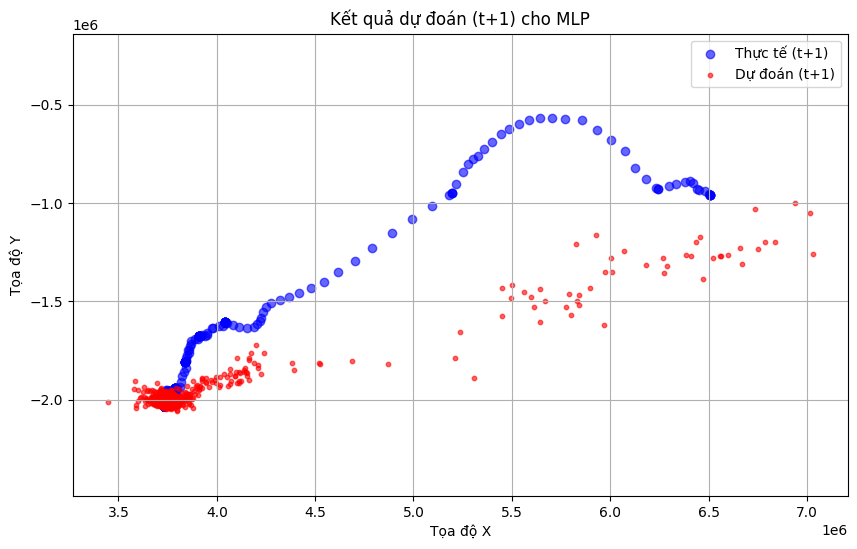

Kết quả đánh giá cho MLP (Tọa độ gốc):
  MAE: 63131.7753
  R2 Score: 0.8151
  ADE: 98639.18
  FDE: 113682.41

--- BẢNG KẾT QUẢ TỔNG HỢP ---


,MAE,R2,ADE,FDE
LinearRegression,39892.309724,0.921112,60555.172574,106329.979592
RandomForest,51223.384421,0.717325,78388.919162,100463.582198
XGBoost,51544.265712,0.671557,81189.570173,101106.493302
KNN,69693.112356,0.659716,108816.564898,117361.297603
MLP,63131.775300,0.815103,98639.180016,113682.407084


In [17]:
import matplotlib.pyplot as plt

# scaler_target = joblib.load('scaler_target.joblib')

final_results = {} 

for model_name, model in model_results.items():
    print(f"\n--- Đánh giá {model_name} ---")

    y_pred = model.predict(X_test)
    
    y_pred_to_scale = y_pred.reshape(-1, NUM_TARGETS)
    y_test_to_scale = y_test.reshape(-1, NUM_TARGETS)

    y_pred_actual = scaler_target.inverse_transform(y_pred_to_scale) 
    y_test_actual = scaler_target.inverse_transform(y_test_to_scale)   

    plt.figure(figsize=(10, 6))
    
    y_test_actual_3d = y_test_actual.reshape(-1, FORECAST_HORIZON, NUM_TARGETS)
    y_pred_actual_3d = y_pred_actual.reshape(-1, FORECAST_HORIZON, NUM_TARGETS)

    plt.scatter(y_test_actual_3d[:, 0, 0], y_test_actual_3d[:, 0, 1], label='Thực tế (t+1)', color='blue', alpha=0.6)
    plt.scatter(y_pred_actual_3d[:, 0, 0], y_pred_actual_3d[:, 0, 1], label='Dự đoán (t+1)', color='red', alpha=0.6, s=10)
    
    plt.title(f"Kết quả dự đoán (t+1) cho {model_name}")
    plt.xlabel("Tọa độ X") 
    plt.ylabel("Tọa độ Y") 
    plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)

    ade_val = ade(y_test_actual_3d, y_pred_actual_3d).numpy()
    fde_val = fde(y_test_actual_3d, y_pred_actual_3d).numpy()

    final_results[model_name] = {"MAE": mae, "R2": r2, "ADE": ade_val, "FDE": fde_val}

    print(f"Kết quả đánh giá cho {model_name} (Tọa độ gốc):")
    print(f"  MAE: {mae:.4f}")
    print(f"  R2 Score: {r2:.4f}")
    print(f"  ADE: {ade_val:.2f}") 
    print(f"  FDE: {fde_val:.2f}") 

print("\n--- BẢNG KẾT QUẢ TỔNG HỢP ---")
results_df = pd.DataFrame(final_results).T
results_df

In [18]:
import optuna

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0), 
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train) 
    y_pred_val = model.predict(X_val)

    y_pred_val_actual = scaler_target.inverse_transform(y_pred_val.reshape(-1, NUM_TARGETS))
    y_val_actual = scaler_target.inverse_transform(y_val.reshape(-1, NUM_TARGETS))

    mae_val = mean_absolute_error(y_val_actual, y_pred_val_actual)
    return mae_val

def objective_knn(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),
        'n_jobs': -1
    }

    if params['metric'] == 'minkowski':
        params['p'] = trial.suggest_int('p', 1, 5)

    model = KNeighborsRegressor(**params)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)

    y_pred_val_actual = scaler_target.inverse_transform(y_pred_val.reshape(-1, NUM_TARGETS))
    y_val_actual = scaler_target.inverse_transform(y_val.reshape(-1, NUM_TARGETS))

    mae_val = mean_absolute_error(y_val_actual, y_pred_val_actual)
    return mae_val

def objective_mlp(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 32, 256))

    params = {
        'hidden_layer_sizes': tuple(layers),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'max_iter': 300, 
        'early_stopping': True, 
        'validation_fraction': 0.15, 
        'n_iter_no_change': 20, 
        'random_state': 42
    }
    if params['solver'] == 'sgd':
         params['learning_rate'] = 'adaptive' 

    model = MLPRegressor(**params)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)

    y_pred_val_actual = scaler_target.inverse_transform(y_pred_val.reshape(-1, NUM_TARGETS))
    y_val_actual = scaler_target.inverse_transform(y_val.reshape(-1, NUM_TARGETS))

    mae_val = mean_absolute_error(y_val_actual, y_pred_val_actual)
    return mae_val

def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror', 
        'eval_metric': 'mae',            
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), 
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), 
        'random_state': 42,
        'n_jobs': -1 
    }

    model = XGBRegressor(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=20, 
        verbose=False 
    )

    y_pred_val = model.predict(X_val)

    y_pred_val_to_scale = y_pred_val.reshape(-1, NUM_TARGETS)
    y_val_to_scale = y_val.reshape(-1, NUM_TARGETS)

    y_pred_val_actual = scaler_target.inverse_transform(y_pred_val_to_scale)
    y_val_actual = scaler_target.inverse_transform(y_val_to_scale)

    mae_val = mean_absolute_error(y_val_actual, y_pred_val_actual)

    return mae_val

In [19]:
N_TRIALS = 30 
TIMEOUT = 300 

print("\n--- Optimizing RandomForest ---")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=N_TRIALS, timeout=TIMEOUT)
best_params_rf = study_rf.best_params
best_mae_rf = study_rf.best_value
print(f"Best RF MAE (val): {best_mae_rf:.4f}")
print(f"Best RF Params: {best_params_rf}")

print("\n--- Optimizing KNN ---")
study_knn = optuna.create_study(direction='minimize')
study_knn.optimize(objective_knn, n_trials=N_TRIALS, timeout=TIMEOUT)
best_params_knn = study_knn.best_params
best_mae_knn = study_knn.best_value
print(f"Best KNN MAE (val): {best_mae_knn:.4f}")
print(f"Best KNN Params: {best_params_knn}")

print("\n--- Optimizing MLP ---")
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(objective_mlp, n_trials=N_TRIALS, timeout=TIMEOUT)
best_params_mlp = study_mlp.best_params
best_mae_mlp = study_mlp.best_value
print(f"Best MLP MAE (val): {best_mae_mlp:.4f}")
print(f"Best MLP Params: {best_params_mlp}")

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, timeout=TIMEOUT)
best_params_xgb = study_xgb.best_params
best_mae_xgb = study_xgb.best_value

print(f"Best XGB MAE (val): {best_mae_xgb:.4f}")
print(f"Best XGB Params: {best_params_xgb}")


best_n_layers = best_params_mlp.get('n_layers', 1) 
best_layers = tuple(best_params_mlp[f'n_units_l{i}'] for i in range(best_n_layers))

final_mlp_params = {k: v for k, v in best_params_mlp.items() if not k.startswith('n_units_l') and k != 'n_layers'}
final_mlp_params['hidden_layer_sizes'] = best_layers

[I 2025-12-14 12:49:29,556] A new study created in memory with name: no-name-6e5b032c-695d-41d8-a80e-c3fc5f25203b



--- Optimizing RandomForest ---


[I 2025-12-14 12:56:36,424] Trial 0 finished with value: 22138.145807269073 and parameters: {'n_estimators': 250, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.9414791527576786}. Best is trial 0 with value: 22138.145807269073.
[I 2025-12-14 12:56:36,426] A new study created in memory with name: no-name-5caf2fd2-06ca-49c6-938f-753a9291aca3


Best RF MAE (val): 22138.1458
Best RF Params: {'n_estimators': 250, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.9414791527576786}

--- Optimizing KNN ---


[I 2025-12-14 12:56:36,646] Trial 0 finished with value: 116655.95073207488 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 116655.95073207488.
[I 2025-12-14 12:56:39,823] Trial 1 finished with value: 36042.66325081319 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 36042.66325081319.
[I 2025-12-14 12:56:40,041] Trial 2 finished with value: 111371.72811979093 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2}. Best is trial 1 with value: 36042.66325081319.
[I 2025-12-14 12:57:54,721] Trial 3 finished with value: 127517.98342017077 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski', 'p': 3}. Best is trial 1 with value: 36042.66325081319.
[I 2025-12-14 12:57:54,955] Trial 4 finished with value: 111612.26957856504 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'euclidean'}. Best 

Best KNN MAE (val): 35660.4982
Best KNN Params: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}

--- Optimizing MLP ---


[I 2025-12-14 13:01:48,726] Trial 0 finished with value: 86081.36512068244 and parameters: {'n_layers': 1, 'n_units_l0': 189, 'activation': 'tanh', 'solver': 'adam', 'alpha': 2.848464596652714e-05, 'learning_rate_init': 0.00012053814152241989}. Best is trial 0 with value: 86081.36512068244.
[I 2025-12-14 13:01:57,276] Trial 1 finished with value: 482522.4790181722 and parameters: {'n_layers': 1, 'n_units_l0': 45, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0009441980939966639, 'learning_rate_init': 0.00034472692294530683}. Best is trial 0 with value: 86081.36512068244.
[I 2025-12-14 13:02:06,826] Trial 2 finished with value: 59379.89456309496 and parameters: {'n_layers': 3, 'n_units_l0': 102, 'n_units_l1': 228, 'n_units_l2': 110, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0005189594774746152, 'learning_rate_init': 0.009953970923677795}. Best is trial 2 with value: 59379.89456309496.
[I 2025-12-14 13:02:27,105] Trial 3 finished with value: 76575.44115189955 and parameters

Best MLP MAE (val): 59379.8946
Best MLP Params: {'n_layers': 3, 'n_units_l0': 102, 'n_units_l1': 228, 'n_units_l2': 110, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0005189594774746152, 'learning_rate_init': 0.009953970923677795}


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-14 13:09:16,635] Trial 0 finished with value: 21541.22374212978 and parameters: {'n_estimators': 900, 'learning_rate': 0.21779029898738642, 'max_depth': 13, 'subsample': 0.5039596140567455, 'colsample_bytree': 0.6053519209330627, 'gamma': 0.0018968630977449137, 'reg_alpha': 1.1479278951059918e-08, 'reg_lambda': 6.101484486444368e-07}. Best is trial 0 with value: 21541.22374212978.
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-12-14 14:36:45,282] Trial 1 finished with value: 21844.68194581745 and paramete

Best XGB MAE (val): 21541.2237
Best XGB Params: {'n_estimators': 900, 'learning_rate': 0.21779029898738642, 'max_depth': 13, 'subsample': 0.5039596140567455, 'colsample_bytree': 0.6053519209330627, 'gamma': 0.0018968630977449137, 'reg_alpha': 1.1479278951059918e-08, 'reg_lambda': 6.101484486444368e-07}


In [ ]:
optimized_models = {
    "LinearRegression": LinearRegression(), 
    "RandomForest_Opt": RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1),
    "XGBoost_Opt": XGBRegressor(objective='reg:squarederror', **best_params_xgb, random_state=42, n_jobs=-1),
    "KNN_Opt": KNeighborsRegressor(**best_params_knn, n_jobs=-1),
    "MLP_Opt": MLPRegressor(**final_mlp_params, max_iter=500, 
                             early_stopping=True, validation_fraction=0.1, n_iter_no_change=30, random_state=42)
}

final_optimized_results = {}
model_results_optimized = {} 

print("\n--- Training and Evaluating Optimized Models ---")

for model_name, model in optimized_models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()

    if "XGBoost" in model_name:
         model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=30, 
            verbose=False
        )
    elif "MLP" in model_name:
         model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)

    print(f"Training finished in {time.time() - start_time:.2f}s.")
    model_results_optimized[model_name] = model 

    print(f"Evaluating {model_name} on Test set...")
    y_pred_test_scaled = model.predict(X_test)

    y_pred_test_actual = scaler_target.inverse_transform(y_pred_test_scaled.reshape(-1, NUM_TARGETS))
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, NUM_TARGETS)) # y_test is scaled

    mae_test = mean_absolute_error(y_test_actual, y_pred_test_actual)
    r2_test = r2_score(y_test_actual, y_pred_test_actual)

    y_test_actual_3d = y_test_actual.reshape(-1, FORECAST_HORIZON, NUM_TARGETS)
    y_pred_test_actual_3d = y_pred_test_actual.reshape(-1, FORECAST_HORIZON, NUM_TARGETS)
    ade_test = ade(y_test_actual_3d, y_pred_test_actual_3d).numpy()
    fde_test = fde(y_test_actual_3d, y_pred_test_actual_3d).numpy()

    final_optimized_results[model_name] = {
        "MAE_test": mae_test,
        "R2_test": r2_test,
        "ADE_test": ade_test,
        "FDE_test": fde_test
    }
    print(f"  MAE (Test): {mae_test:.4f}")
    print(f"  R2 (Test): {r2_test:.4f}")
    print(f"  ADE (Test): {ade_test:.2f}")
    print(f"  FDE (Test): {fde_test:.2f}")

print("\n--- FINAL OPTIMIZED RESULTS (Test Set) ---")
results_opt_df = pd.DataFrame(final_optimized_results).T
results_opt_df

for name, model in model_results_optimized.items():
    joblib.dump(model, f'models/{name}.joblib')


--- Training and Evaluating Optimized Models ---

Training LinearRegression...
Training finished in 0.73s.
Evaluating LinearRegression on Test set...
  MAE (Test): 39892.3097
  R2 (Test): 0.9211
  ADE (Test): 60555.17
  FDE (Test): 106329.98

Training RandomForest_Opt...
Training finished in 432.49s.
Evaluating RandomForest_Opt on Test set...
  MAE (Test): 52034.3560
  R2 (Test): 0.7127
  ADE (Test): 79482.85
  FDE (Test): 101629.66

Training XGBoost_Opt...


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training finished in 165.91s.
Evaluating XGBoost_Opt on Test set...
  MAE (Test): 53884.1951
  R2 (Test): 0.6604
  ADE (Test): 84452.90
  FDE (Test): 116898.82

Training KNN_Opt...
Training finished in 0.01s.
Evaluating KNN_Opt on Test set...
  MAE (Test): 69298.1526
  R2 (Test): 0.6171
  ADE (Test): 103857.19
  FDE (Test): 124832.60

Training MLP_Opt...
Training finished in 15.02s.
Evaluating MLP_Opt on Test set...
  MAE (Test): 68973.5843
  R2 (Test): 0.7096
  ADE (Test): 110624.47
  FDE (Test): 132580.19

--- FINAL OPTIMIZED RESULTS (Test Set) ---
